In [1]:
import librosa
import numpy as np
import sys
import pickle
import time
import IPython.display as ipd
import scipy.signal as signal
from scipy.fftpack import fft, ifft, dct, idct
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import CosineTransformTools as ctt 
from dahuffman import HuffmanCodec

In [2]:
def powerlaw_quant(x, mu):
    return np.sign(x)*np.log(1 + mu*np.abs(x))/np.log(1 + mu)

def inv_powerlaw_quant(y, mu):
    return np.sign(y)*((mu + 1)**np.abs(y) - 1)/mu

In [3]:
def quantize(x, S):
    X = x.reshape((-1,1))
    S = S.reshape((1,-1))
    dists = abs(X-S)
    
    nearestIndex = dists.argmin(axis=1)
    quantized = S.flat[nearestIndex]
    
    return quantized.reshape(x.shape)

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=10):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=10):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
def signal_to_noise(original, decoded):
    original = original.astype('float_')
    decoded = decoded.astype('float_')
    diff = len(original) - len(decoded)
    
    if diff < 0:
        decoded = decoded[:diff]
    if diff > 0:
        decoded = np.append(decoded, np.zeros((diff,1)))
        
    signal = np.power(original, 2)
    noise = np.power(original-decoded, 2)
    
    signal = np.where(signal == 0, np.finfo(np.float32).eps, signal)
    noise = np.where(noise == 0, np.finfo(np.float32).eps, noise)
    
    return np.mean(np.log10(signal/noise)*10)

In [6]:
def ath(f):
    return 3.64*np.float_power(f/1000, -0.8) - \
        6.5*np.exp(-0.6*np.power(f/1000 - 3.3, 2)) + \
        np.float_power(10, -3)*np.power(f/1000, 4)

def bark(f):
    return 13*np.arctan(0.00076*f) + 3.5*np.arctan((f/7500)**2)

In [7]:
def load_cd_quality_audio(filename):
    audio, sr = librosa.load(filename, sr=44100, dtype='float_')
    max_int_value = 2**15 - 1
    audio *= max_int_value
    audio = audio.astype('int16')
    return audio, sr
    
x, sr = load_cd_quality_audio("taxman.wav")
fs = 44100

In [8]:
# ipd.Audio(x, rate=44100)
x = x[0:1000000]
x.shape

(1000000,)

In [9]:
def divide_into_frames(signal, npoints):
    # Find out how many frames are needed
    nwholeframes = np.floor(len(signal)/npoints).astype('int')
    nframes = np.ceil(len(signal)/npoints).astype('int')
    # Pad the signal so that its length is divisible by nframes
    padded = np.pad(signal, (0, npoints-len(signal)%nwholeframes), 'constant', constant_values=0.0)
    # Reshape padded signal into nframes rows, each row is one frame
    frames = padded.reshape((nframes, len(padded)//nframes))
    return frames

npoints = 1152
nbands = 32

# Divide original signal into frames, each frame consists of npoints
x_frames = divide_into_frames(x, npoints)
x_frames.shape

(869, 1152)

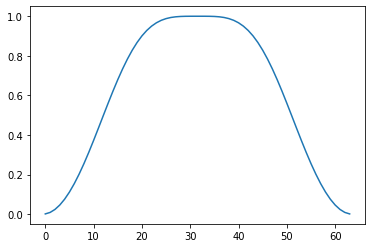

In [10]:
window_length = 64
window_function = np.sin(np.pi / 2 * \
                       np.power(np.sin(np.pi / window_length * \
                       np.arange(0.5, window_length + 0.5)), 2))
num_blocks = 37
plt.plot(window_function)

In [11]:
class TonalClassifier(object):
    def __init__(self):
        small  = np.array([-2, +2])
        medium = np.array([-3, -2, +2, +3]) 
        large  = np.array([-6, -5, -4, -3, -2, +2, +3, +4, +5, +6])
        xlarge  = np.linspace(-12, 12, 25, dtype='int')
        self.neighbourhood = 512 * [None]
        for _k in range(2, 63):
            self.neighbourhood[_k] = small
        for _k in range(63, 127):
            self.neighbourhood[_k] = medium
        for _k in range(127, 255):
            self.neighbourhood[_k] = large
        for _k in range(255, 501):
            self.neighbourhood[_k] = xlarge
    def __call__(self, k, P):
        k_t = []
        P_t = []
        for _k in np.arange(3, 501):
            if (P[_k-1] <= P[_k] and P[_k+1] <= P[_k]):
                js = self.neighbourhood[_k]
                if np.all(P[_k] - P[_k+js] >= 7):
                    k_t.append(_k)
                    P_t.append(P[_k-1] + P[_k] + P[_k+1])
                    P[_k-1] = P[_k] = P[_k+1] = 0.0
        return (np.array(k_t), np.array(P_t))
    

In [12]:
def psyacoustic_analysis(frame):
#     frame = x_frames[500]
    wl = window_length
    x_fr_stft = librosa.stft(frame.astype('float'), wl, wl//2, window=signal.hanning)
    x_fr_stft2 = x_fr_stft**2
    P_k = 2.0 * x_fr_stft2[:(wl // 2 + 1)] / wl ** 2
    P_k[0] = 0.5 * P_k[0]
    if (wl % 2 == 0):
        P_k[-1] = 0.5 * P_k[-1]
    P_k = 10.0 ** (96.0 / 10.0) * P_k
    P_k = 10.0 * np.log10(P_k)

    dt = 1.0 / sr
    k = np.arange(wl // 2 + 1)
    f_k = k * sr / wl
    b_k = bark(f_k)
    ath_k = 10 ** (ath(f_k)/10)

    ath_k.shape = (len(ath_k),1)
    coeffs_bool = (P_k - np.repeat(ath_k, P_k.shape[1], axis=1) <= 0)

    P_tonal = np.zeros(P_k.shape)
    k_tonal = []
    js = np.array([-2, +2])
    P_nontonal = np.copy(P_k)
    for col in range(0, P_k.shape[1]):
        for row in range(3, P_k.shape[0]-3):
            if P_k[row,col] >= P_k[row-1,col] and P_k[row,col] >= P_k[row+1,col]:
                if np.all(P_k[row,col] - P_k[row+js,col] >= 7):
                    P_tonal[row,col] = P_k[row-1,col] + P_k[row,col] + P_k[row+1,col]
                    k_tonal.append((row, col))
                    P_nontonal[row-1,col] = P_nontonal[row,col] = P_nontonal[row+1,col] = 0.0

    decimated_tonal_k = np.zeros(P_k.shape)
    for i in range(len(k_tonal)-1):
        row, col = k_tonal[i]
        next_row, next_col = k_tonal[i+1]
        currP = P_tonal[row, col]
        nextP = P_tonal[next_row, next_col]

        if abs(b_k[row] - b_k[next_row]) < 1:
            if currP >= nextP:
                coeffs_bool[next_row, next_col] = False
            else:
                coeffs_bool[row, col] = False
    
    cb_k = np.array([int(b) for b in np.floor(b_k)])
    crit_bands = {}
    for col in range(0, P_k.shape[0]):
        crit_bands.clear
        for row in range(0, P_k.shape[0]):
            if cb_k[row] not in crit_bands:
                crit_bands[cb_k[row]] = [(P_nontonal[row, col], row)]
            else:
                crit_bands[cb_k[row]].append((P_nontonal[row, col], row))
        
        for band in crit_bands.keys():
            P_sum = sum(i for i, _ in crit_bands[band])
            avg_row = int(round(sum(i for _, i in crit_bands[band])/len(crit_bands[band])))
            coeffs_bool[avg_row, col] = False
            

    return coeffs_bool[1:,:]

In [13]:
# i = 100
# tmp_psaa = psyacoustic_analysis(x_frames[i,:])
# tmp_mdct = ctt.mdct(x_frames[i,:], window_function)
# tmp_mdct[tmp_psaa] = 0
# tmp_imdct = ctt.imdct(tmp_mdct, window_function)
# signal_to_noise(x_frames[i], tmp_imdct)

In [14]:
# b_k

In [15]:
# 
# signal_to_noise(x_frames[i], tmp_imdct)

In [16]:
def filter_banks(x_frames, nbands, num_blocks):
    x_bands = np.zeros((nbands, x_frames.shape[0], num_blocks))
    
    for i in range(0, x_frames.shape[0]):
        coeff_bool = psyacoustic_analysis(x_frames[i,:])
        
        x_bands[:,i,:] = ctt.mdct(x_frames[i,:], window_function)
        x_bands[:,i,:][coeff_bool] = 0
        
    return x_bands

t1 = time.time()
x_bands = filter_banks(x_frames, nbands, num_blocks)
print(time.time() - t1)
x_bands.shape

/home/sweet/2-coursework/434eces/labs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/sweet/2-coursework/434eces/labs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/home/sweet/2-coursework/434eces/labs/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in float_power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sweet/2-coursework/434eces/labs/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


8.861067056655884


(32, 869, 37)

In [17]:
tmp = np.zeros(x_frames.shape)
for i in range(x_bands.shape[1]):
    tmp_imdct = ctt.imdct(x_bands[:,i,:], window_function)
    diff = 1152 - len(tmp_imdct)
    if diff < 0:
        tmp[i,:] = tmp_imdct[:diff]
    if diff > 0:
        tmp[i,:] = np.append(tmp_imdct, np.zeros((diff,1)))

ipd.Audio(tmp.flatten(), rate=44100)

In [18]:
class QuantizedFrame(object):
    def __init__(self, data=np.array([], dtype='float16')):
        self.data = data


In [140]:
# scale_table = np.array([14, 14, 14, 15, 15, 15, 16, 16, 16, 18, 18, \
#                    18, 18, 18, 18, 18, 25, 25, 25, 32, 32, 32, 32, 32, 32, 32, \
#                    32, 32, 32, 32, 32, 32], dtype='uint8')

# scale_table = np.array([16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, \
#                    23, 23, 18, 18, 18, 25, 25, 32, 32, 32, 32, 32, 32, 32, 32, \
#                    32, 32, 32, 32, 32, 32], dtype='uint8')

scale_table = np.array([19, 19, 19, 19, 19, 20, 21, 21, 32, 23, 23, \
                   23, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, \
                   32, 32, 32, 32, 32, 32], dtype='uint8')

def quantization(x_bands):
    max_bits = np.max(scale_table)
    quantized_signal = []
#     frame_separator = 2**(max_bits+1)
    for i in range(0, x_bands.shape[1]):
        quantfr = QuantizedFrame()
        for j in range(0, x_bands.shape[0]):
            bit_alloc = scale_table[j]
            quantized_mdct = powerlaw_quant(x_bands[j,i,:], 255)
            quantized_mdct = quantized_mdct/(2**bit_alloc)
#             print(signal_to_noise(x_subbands[j,i,:], inv_powerlaw_quant(quantized_mdct*band_smr,255)))
            quantized_mdct = quantized_mdct.astype('float16')
            quantfr.data = np.append(quantfr.data, quantized_mdct)

        quantized_signal.append(quantfr)
    
    return quantized_signal

t1 = time.time()
quantized_signal = quantization(x_bands)
print(time.time() - t1)

0.6200919151306152


In [20]:
class EncodedSignal(object):
    def __init__(self):
        self.data = None
        self.scale_table = None

In [141]:
import bz2

def encoding(quantized_signal):
    encoded_signal = EncodedSignal()
    encoded_signal.data = quantized_signal
    encoded_signal.scale_table = scale_table
    i_str = pickle.dumps(encoded_signal)
    compressed_signal = bz2.compress(i_str)
    
    return compressed_signal

compressed_signal = encoding(quantized_signal)

def compressionRatio(original, decoded):
    o_str = pickle.dumps(original)
    e_str = pickle.dumps(decoded)
    return sys.getsizeof(o_str)/sys.getsizeof(e_str)

compressionRatio(x,compressed_signal)

7.074522869714076

In [142]:
def decode(encoded_signal):
    decompressed_signal = pickle.loads(bz2.decompress(compressed_signal))
    empty_frame = [0]*npoints
    mdct_per_frame = num_blocks
    decoded_signal = np.zeros((len(decompressed_signal.data), npoints))

    max_bits = np.max(decompressed_signal.scale_table)

    for i, frame in enumerate(decompressed_signal.data):
        decoded_mdct = np.zeros((nbands, num_blocks))
    #         frame_data = np.array(huffman_decoder.decode(frame.data))
        for j in range(0, len(decompressed_signal.scale_table)):
            scale_factor = decompressed_signal.scale_table[j]
            start = j*mdct_per_frame
            end = (j+1)*mdct_per_frame
            encoded_mdct = frame.data[start:end]*(2**scale_factor)
            decoded_mdct[j] = inv_powerlaw_quant(encoded_mdct, 255)
        decoded_frame = ctt.imdct(decoded_mdct, window_function)

        diff = 1152 - len(decoded_frame)
        if diff < 0:
            decoded_signal[i,:] = decoded_frame[:diff]
        if diff > 0:
            decoded_signal[i,:] = np.append(decoded_frame, np.zeros((diff,1)))

    return decoded_signal.flatten().astype('int16')

t1 = time.time()
decoded_signal = decode(compressed_signal)
print(time.time() - t1)
print(signal_to_noise(x, decoded_signal.flatten()))
ipd.Audio(decoded_signal.flatten(), rate=44100)

0.4972262382507324
21.030325035045205


In [27]:
# decoded_signal[100:]